# Example 4: Wishart Planted Ensemble with the CIM

This notebook serves as an introduction to utilizing the coherent Ising machine for MAX-CUT problems. The key goals of this notebook is to provide a parameter choice description for solving a Wishart Planted ensemble problem with our CIM simulator.

TThe Wishart Planted Ensemble consists of instances of varying hardness, decided a global parameter $\alpha$, which is inversely proportional to the hardness for heuristic solvers for $\alpha \leq 1$.

$$ H = -\sum_{1\leq i \leq j \leq N} J_{ij}\sigma_i \sigma_j$$

where we have an $N \times N$ matrix for $J$ (which is our spin coupling matrix) and an $N$-dimensional vector $h$ (which serves as our external field terms), along with each spin $\sigma_i \in \{ -1, 1\}$.  

We provide three implementations of the CIM: chaotic amplitude control (CAC), amplitude-heterogeneity correction (AHC), and amplitude-heterogeneity correction with external field terms (AHC). The first two solvers do not have an external field, while the latter requires an external field $h$.

Problems generated from the Wishart planted ensemble can be mapped to Ising problems with no external field, so either the CAC solver or the AHC no external field solver can be used. 

In [2]:
#Initialization and Imports
import sys
from pathlib import Path
sys.path.append(str(Path.cwd()) + "\\..\\") # append repo to list of search directories 
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from cim_optimizer.solve_Ising import *
from cim_optimizer.CIM_helper import brute_force

%matplotlib inline

## Loading the Ising Coupling Matrix & Planted Ground State Energy

The coupling matrices and planted ground-state Ising energy are retrieved from delimited files via the helper function load_matrix_from_rudy(), or simply npz, csr_matrix, or any other delimited file reader.


In [3]:
instance_path_str_wishart = str(Path.cwd()) + "\\..\\instances\\Wishart_Planted_Ensemble\\"

# 50 spin Wishart Planted Ensemble problem
N = 50
wpe_id = 1 # select first example of 50 spin Wishart Planted Ensemble Ising problem
J, h = load_adjMatrix_from_rudy(instance_path_str_wishart + f"Wishart_N{N}_{wpe_id}.txt", delimiter='\t', index_start=0, preset_size=N)

In [4]:
# Load the matrix
from scipy.sparse import csr_matrix
import copy
file_array = np.loadtxt(instance_path_str_wishart + f"Wishart_N{N}_{wpe_id}.txt", unpack=True)
rows = file_array[0, :].astype(int)
cols = file_array[1, :].astype(int)
vals = file_array[2, :]

# Create a sparse matrix representing the W in the Wishart model
J = csr_matrix((vals, (rows, cols)), shape = (50, 50))
J = (J + J.T) / 2. # Note that this is the symmetric form of the Ising problem
J = J.A
J=-J
E_ground = -1534000/2
print("The ground state energy is: {}".format(E_ground))

The ground state energy is: -767000.0


## Hyperparameters and their background reasoning
We now apply the CAC CIM model to our J matrix for a single trial with tuned instance-specific hyperparameters, given the hardness of the Wishart Ising instances.

Given an unnormalized Ising problem, the parameter choices (as well as explanations for the choices) are as follows: 

- cac_beta = 0.0020  # Generally, a larger value of beta will increase the success probability and decrease TTS, but will put the CAC at risk of instability. As a result, finely tuning this, incrementing from this base value until diverging runs occur, tends to lend better performance.

- cac_r = -10.0 # This is also known as the parameter "p" (linear gain), which can take on either positive or negative values based on the nature of the Ising problem, and can vary over orders of magnitude as well. Ideally, this parameter should be tuned ± 1 order of magnitude, spanning the largest parameter space in our sweeps/tunings. 

- cac_gamma = 0.08 # This determines the rate of increase of the error variable rate of change. It's recommended to finely tune this parameter ± 100% of its nominal value. 

- cac_alpha = 0.25 # This positive parameter will indirectly determine the steady-state amplitude. It's recommended to tune this parameter ± 1 order of magnitude, though it may affect the runs if set to zero or a value too large.

- cac_rho = 5 # This parameter should stay roughly fixed around this value. In altenate Wishart-specific algorithms, this parameter is unused as the target amplitude is ramped linearly.

- cac_tau = 2000 # This parameter determintes the number of euler-steps within the simulation that would passs since the minimum Ising energy has decreased, or since the last reset of the error variable rate of change (ξ), which can be useful for helping the system escape from being trapped in the cost function's local minima. The affect of this parameter on the performance varies instance-to-instance, though it largely stays the same as long as it is < num_timesteps_per_run.

- cac_mu = 0.5 # This parameter determines the coefficient of the non-linear cubic term within the CIM-CAC's equations of motion, thus partially determining the steady-state amplitude of the spins.

- cac_delta = 10 # This determines the readiness of the target amplitude to shift once the CAC-solver's spin configuration corresponds to an Ising energy lower the the minimum Ising energy found so far within a run. Ideally, this parameter would remain large (~10) even for steeper cost functions, due to the variance desired within the spin evolution in sampling different areas in state-space.

In [7]:
#Parameter Box
####################################################################################################################################################################################################
run_number = 2000
batch_number = 1000
alpha = 0.25
beta = 0.0020
gamma = 0.08 
delta = 10
rho = 5
tau = 2000
p = -10.0
mu = 0.5
total_roundtrips = 5000
euler_step = 0.00625
noise_level=0.5

In [10]:
test = Ising(J).solve(cac_noise=noise_level, cac_gamma=gamma, cac_beta = beta, cac_delta=delta, cac_r=p, cac_mu = mu, cac_rho = rho, cac_alpha=alpha, cac_tau = tau, num_timesteps_per_run=total_roundtrips, cac_time_step=euler_step, num_parallel_runs
                      =batch_number, num_runs=run_number, target_energy=0.95*E_ground,use_GPU=True)
print(f"Best Percentage: {test.result.lowest_energy/E_ground*100}")
print(f"Avg. Percentage: {np.mean(test.result.energies)/E_ground*100}")
success_counter=0
for E in (test.result.energies):
    if E <= 1*E_ground:
        success_counter += 1
if success_counter==0:
    mvms_to_solution = 0 #indicates no solution found
else:
    mvms_to_solution = total_roundtrips/(success_counter/run_number)
print("Approx. MVM's to Solution:", mvms_to_solution)
print(success_counter)
print(f"Success Probability: {success_counter/run_number*100}%" )

No External Field Detected
Target Ising Energy: -728650.0.
Best Ising Energy Found: -767000.0.
Corresponding Spin Configuration: [-1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1.
  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1.].
Time Elapsed: 10.056125164031982.
Number of Runs Completed: 2000.
Success Probability: 0.306.
Best Percentage: 100.0
Avg. Percentage: 94.70714993481096
Approx. MVM's to Solution: 1250000.0
8
Success Probability: 0.4%


## Plot Spin Amplitude Time-Evolution
As can be seen in the following spin trajectories, spin crossings continuously occur throughout the allotted number of time-steps per run, thus sampling different states in state-space. Occasionally, however, the spin evolution can enter periodic motion, also known as limit cycles, in which it is no longer optimal to continue the run without re-initializing the spin variables.

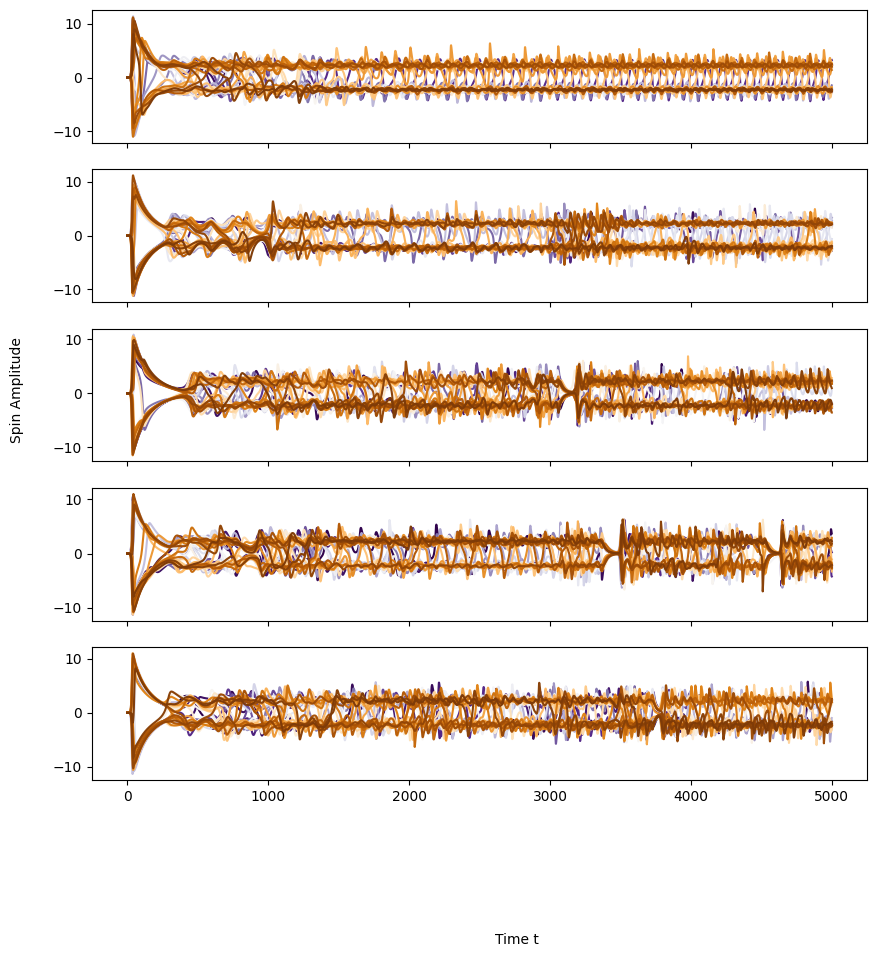

In [12]:
test.result.plot_spin_trajectories(plot_type="spins", trajectories_to_plot=[0,1,2,3,4])